# GBM

## Stock price simulation using geometric brownian motion process

### Author: Konstantinos A. Mountris, CQF, PhD

In [1]:
# Imported libraries
import numpy as np
import matplotlib.pyplot as plt

## Understanding Geometric Brownian Motion:

Geometric Brownian Motion (GBM) is a continuous-time stochastic process characterized by the logarithmic growth of a variable. It is primarily used to model the price dynamics of financial assets, assuming that the logarithm of the asset's price follows a Brownian Motion with drift and volatility. 

The key features of GBM are:
* exponential growth
* random fluctuations
* absence of price boundaries.


The GBM process is described by the following stochastic differential equation (SDE):

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

where

* $S_t$ is the price of the underlying at time $t$
* $\mu$ is the expected return or drift of the stock price
* $\sigma$ is the constant volatility
* $dW_t$ is the infinitesimal Wiener process or Brownian motion, representing the random component of the stock price.

By definition, the increment $dW_t$ is normally distributed with mean zero and variance $dt$, which means that $dW_t$ can be written as $dW_t = dt Z$, where $Z$ is a standard normal random variable.

From Itô's lemma and the above definition, we obtain the closed form solution:

$$
S_{t+dt} = S_t exp \left\{(\mu -\frac{1}{2} \sigma^2) dt + \sigma \sqrt{dt} Z \right\}
$$


## Euler-Maruyama Scheme

The Euler-Maruyama scheme is a popular and straightforward approach used to approximate solutions to stochastic differential equations (SDEs) numerically. This scheme enables us to simulate Geometric Brownian Motion (GBM) paths incrementally by discretizing the time interval. At each step, we enhance the GBM path by incorporating a Wiener increment, which is directly related to the square root of the time step. Nevertheless, it is essential to acknowledge that the Euler-Maruyama scheme introduces certain biases and can lead to notable numerical errors, especially when confronted with extensive time steps or volatile processes.

The **Euler-Maruyama** scheme is obtained by simulating price paths using the discrete form of the SDE:

$$
\delta S_t = r S_t \delta t + \sigma S_t \sqrt{\delta t} \phi
$$

which in time stepping form is given by:

$$
S_{t+\delta t} = S_t * \left(1 + r \delta t + \sigma \sqrt{\delta t} \phi \right)
$$


## Milstein Scheme

The Milstein scheme is another commonly employed method for numerically approximating solutions to stochastic differential equations (SDEs). However, it introduces an additional corrective term that accounts for the second derivative of the SDE solution. This correction improves the accuracy of the approximation, particularly when dealing with strong nonlinearity. Despite its advantages, it's important to note that the Milstein scheme can still exhibit some biases and may generate numerical errors under certain conditions, such as large time steps or highly volatile processes.

To obtain the **Milstein** scheme we apply a Taylor expansion to the closed form solution and is given by:

$$
S_{t+\delta t} = S_t * \left(1 + (r-\frac{1}{2}\sigma^2) \delta t + \sigma \sqrt{\delta t} \phi + \frac{1}{2}\sigma^2 \phi^2 \delta t \right)
$$

Due to the addition of the corrective term, the Milstein scheme delivers higher accuracy compared to the Euler-Maruyama scheme. In $\mathcal{O}$ notation, the Milstein scheme has $\mathcal{O}(\delta t)$ accuracy, while the Euler-Maruyama scheme has $\mathcal{O}(\sqrt{\delta t})$ accuracy.

#### Implementation of the geometric Brownian motion process to simulate stock prices:

In [2]:
# Implementation of the geometric Brownian motion process.
def gbm(S0:float, mu:float, sigma:float, T:float, n:int, m:int, method:str):
    """
    Stock price simulation as a geometric Brownian motion process
    
    Parameters:
    - S0: float, the initial stock price
    - mu: float, the drift coefficient
    - sigma: float, the volatility coefficient
    - T: float, the time horizon
    - n: int, the number of time steps
    - m: int, the number of simulations
    - method: str, the method for solving the GBM process
              options are: 'cf' - closed form, 'em' - Euler-Maruyama, 'ml' - Milstein
    
    Returns:
    - np.array with shape (n+1,), solution of the geometric Brownian motion process 
    """
    
    # Set random seed to ensure the same random distribution in the three price path simulations
    np.random.seed(1234)

    # Generate standard normally distributed random numbers
    phi = np.random.normal(size=(m,n))
    
    # Compute the parameters of the lognormal distribution
    dt = T / n
    drift = (mu - 0.5 * sigma**2) * dt
    
    # Simulate the geometric Brownian motion
    S = np.zeros((m,n+1))
    S[:,0] = S0
    if method == 'cf':
        for i in range(1,n+1):
            S[:,i] = S[:,i-1] * np.exp(drift + sigma * np.sqrt(dt) * phi[:,i-1])
    elif method == 'em':
        for i in range(1,n+1):
            S[:,i] = S[:,i-1] * (1.0 + drift + sigma * np.sqrt(dt) * phi[:,i-1])
    elif method == 'ml':
        for i in range(1,n+1):
            S[:,i] = S[:,i-1] * (1.0 + drift + sigma * np.sqrt(dt) * phi[:,i-1] + 0.5 * sigma**2 * phi[:,i-1]**2 * dt)
    else:
        error("Unexpected GBM method. Options are: 'cf' - closed form, 'em' - Euler-Maruyama, 'ml' - Milstein")
        
    return S

#### Implementation of root mean square error computation

In the function below I compute the root mean square error (RMS) to compare later on the solutions obtained by the different schemes for the simulation of the GBM process.

In [3]:
def rms_error(x:np.array, y:np.array):
    """
    Computes the root mean square error between two numpy arrays x and y.
    
    Parameters:
    - x: np.array of shape (m,n), the first numpy array
    - y: np.array of shape (m,n), the second numpy array
    
    Returns:
    - np.array of shape (m,n), the root mean square error between x and y
    """
    
    return np.sqrt(np.mean((x - y)**2, axis=1))

## Comparing the Euler-Maruyama and Milstein schemes

To compare the Euler-Maruyama and Milstein schemes we will simulate a stock price path using the two schemes and we will compute the root mean square error of the two schemes compared to the close form solution. 

We will consider a stock with the following data:
* initial stock price, $S_0 = 100$
* drift coefficient, $\mu = 0.05$
* volatility coefficient, $\sigma = 0.05$
* time horizon (years), $T = 1$
* number of time steps (daily sampling), $n = 252$
* number of simulations (price paths), $m = 1$

#### Stock price simulation as GBM process

In [4]:
# Stock data
S0 = 100       # initial stock price
mu  = 0.05     # drift coefficient
sigma = 0.05   # volatility coefficient
T = 1          # time horizon
n = 252        # number of time steps (assuming daily sampling)
m = 1          # number of simulations

# Closed form solution of the stock price path
S_cf = gbm(S0, mu, sigma, T, n, m, 'cf')

# Euler-Maruyama solution of the stock price path
S_em = gbm(S0, mu, sigma, T, n, m, 'em')

# Milstein solution of the stock price path
S_ml = gbm(S0, mu, sigma, T, n, m, 'ml')

#### Plot stock price path

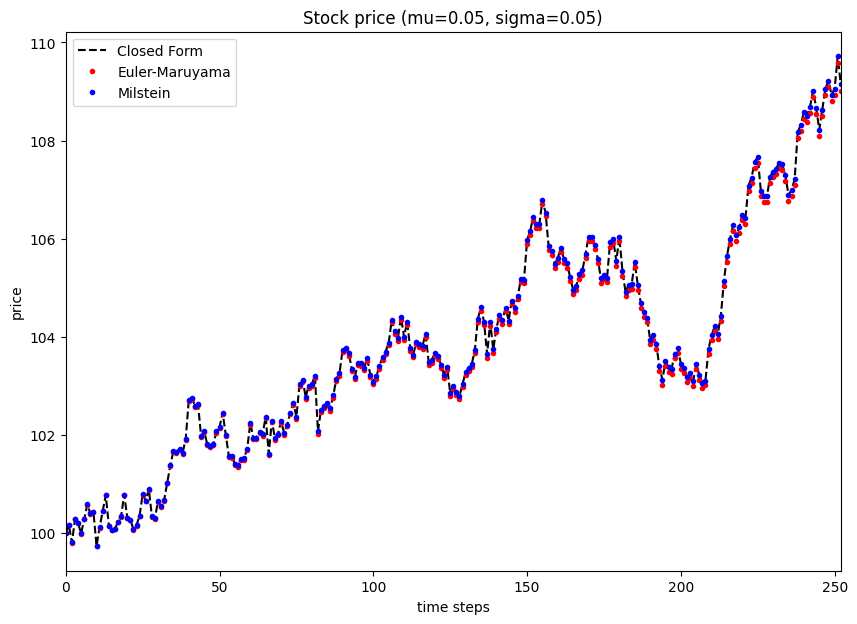

In [5]:
# Plot simulated paths
fig = plt.figure(figsize=(10,7))
plt.plot(S_cf.T, '--', color='k', label='Closed Form')
plt.plot(S_em.T, '.', color='r', label='Euler-Maruyama')
plt.plot(S_ml.T, '.', color='b', label='Milstein')
plt.xlabel('time steps'), plt.ylabel('price')
plt.xlim(0, 252)
plt.legend()
plt.title('Stock price (mu=0.05, sigma=0.05)');
plt.show()

#### Computation of root mean square error

In [6]:
# Compute the root mean square errors for the two numerical schemes.
print("Root mean square (RMS) errors for stock price with mu=0.05 and sigma=0.05")
print(f"Euler-Maruyama scheme RMS error: {rms_error(S_em,S_cf)}")
print(f"Milstein scheme RMS error: {rms_error(S_ml,S_cf)}")

Root mean square (RMS) errors for stock price with mu=0.05 and sigma=0.05
Euler-Maruyama scheme RMS error: [0.07476178]
Milstein scheme RMS error: [0.00057742]


From the plot of the stock price path and the RMS errors above it is evident that Milstein scheme provides more accurate results compared to the Euler-Maruyama scheme. Let's see now the two schemes perform when we consider a higher volatility $\sigma = 0.2$.


#### Stock price path with mu=0.05 and sigma=0.2

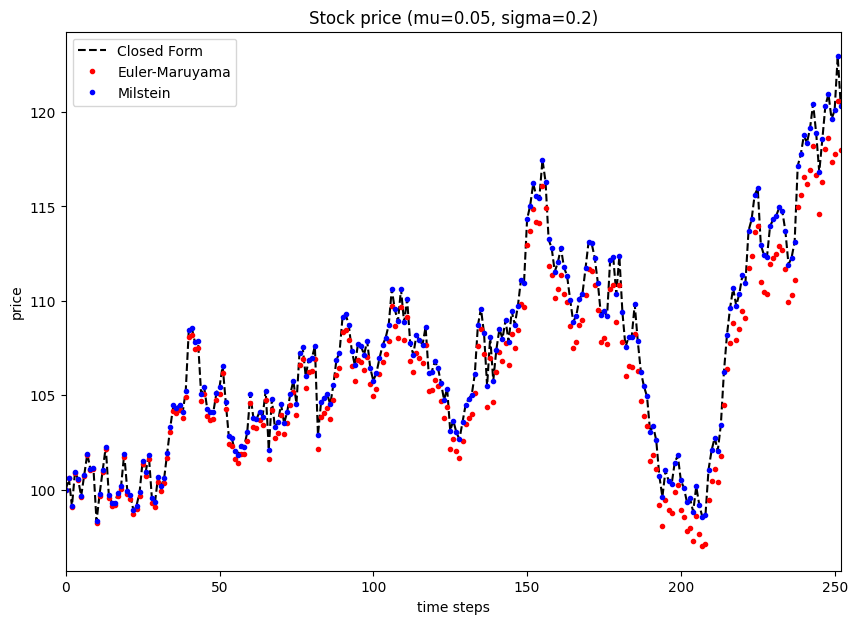

In [7]:
sigma = 0.2   # volatility coefficient

# stock price path
S_cf = gbm(S0, mu, sigma, T, n, m, 'cf')
S_em = gbm(S0, mu, sigma, T, n, m, 'em')
S_ml = gbm(S0, mu, sigma, T, n, m, 'ml')

# Plot simulated paths
fig = plt.figure(figsize=(10,7))
plt.plot(S_cf.T, '--', color='k', label='Closed Form')
plt.plot(S_em.T, '.', color='r', label='Euler-Maruyama')
plt.plot(S_ml.T, '.', color='b', label='Milstein')
plt.xlabel('time steps'), plt.ylabel('price')
plt.xlim(0, 252)
plt.legend()
plt.title('Stock price (mu=0.05, sigma=0.2)');
plt.show()

In [8]:
# Compute the root mean square errors for the two numerical schemes.
print("Root mean square (RMS) errors for stock price with mu=0.05 and sigma=0.2")
print(f"Euler-Maruyama scheme RMS error: {rms_error(S_em,S_cf)}")
print(f"Milstein scheme RMS error: {rms_error(S_ml,S_cf)}")

Root mean square (RMS) errors for stock price with mu=0.05 and sigma=0.2
Euler-Maruyama scheme RMS error: [1.23324483]
Milstein scheme RMS error: [0.0013194]


As expected the error is increased for both schemes when the volatility coefficient is increased. However, the error for the Milstein scheme remains low and the solution is in good agreement with the closed form solution. On the other hand, the Euler-Maruyama scheme leads to inaccurate results as can be observed.

### Conclusion

Euler-Maruyama and Milstein schemes can be used to simulate stock price as a geometric Brownian motion process. Both numerical processes introduce a higher error as the volatility coefficient increases. However, the Milstein scheme is $\mathcal{O}(\delta t)$ accurate while the Euler-Maruyama scheme is $\mathcal{O}(\sqrt{\delta t})$ accurate. As it was observed, the Milstein scheme produces more accurate results compared to the Euler-Maruyama scheme. Therefore, it is the preffered numerical method for the approximation of the GBM process.